In [1]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
train_data = MNIST(root='data', train=True, transform=ToTensor(), target_transform=None, download=True)

In [3]:
classes_name = train_data.classes
print(f'The classes name are:\n{classes_name}')

The classes name are:
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
print(f'The number of training samples are {len(train_data)}')

The number of training samples are 60000


In [5]:
X, y = train_data[0]

In [6]:
print(f'The shape of a single input sample is {X.shape} and label is an integer')

The shape of a single input sample is torch.Size([1, 28, 28]) and label is an integer


In [7]:
test_data = MNIST(root='data', train=False, transform=ToTensor(), download=True)

In [8]:
print(f'The number of test samples are {len(test_data)}')

The number of test samples are 10000


And of course the shape of X, y in test_data is same as training_data

In [9]:
import matplotlib.pyplot as plt

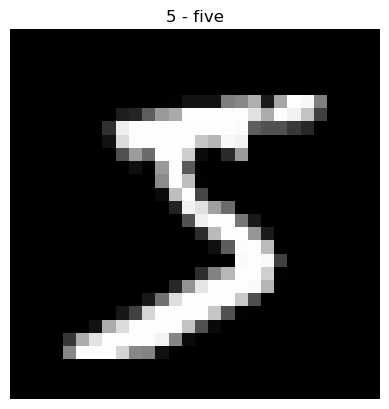

In [10]:
image, label = train_data.data[0], train_data.targets[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.axis(False)
plt.title(classes_name[label]);

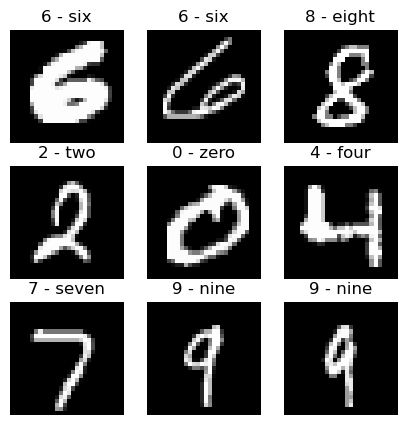

In [11]:
# plot the first 9 images with corresponding labels
torch.manual_seed(42)
fig = plt.figure(figsize=(5, 5))
for i in range(1, 10):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(3, 3, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(classes_name[label])
    plt.axis(False);

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [14]:
print('We use dataloaders to put dataset into batches')
print(f'Now we have {len(train_dataloader)} and {len(test_dataloader)} batches in train and test dataloaders')
print('size of batch: 32')

We use dataloaders to put dataset into batches
Now we have 1875 and 313 batches in train and test dataloaders
size of batch: 32


In [15]:
X, y = next(iter(train_dataloader))
print(f'If we iterate over train_dataloader, we can see that the shape of input samples are {X.shape}\nand the shape of labels are {y.shape}')

If we iterate over train_dataloader, we can see that the shape of input samples are torch.Size([32, 1, 28, 28])
and the shape of labels are torch.Size([32])


In [16]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=hidden_units, kernel_size=3,
                                                    padding=1),
                                           nn.ReLU(),
                                           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                                                    padding=1),
                                           nn.ReLU(),
                                           nn.MaxPool2d(kernel_size=2, stride=2),
                                           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                                                    padding=1),
                                           nn.ReLU(),
                                           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                                                    padding=1),
                                           nn.ReLU(),
                                           nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=7*7*hidden_units, out_features=output_shape))
    def forward(self, x):
        return self.fc(self.cnn(x))

In [17]:
torch.manual_seed(42)
model_on_cpu = MNISTModel(input_shape=1, hidden_units=10, output_shape=10).cpu()

In [18]:
model_on_cpu

MNISTModel(
  (cnn): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_on_cpu.parameters(), lr=0.1)

In [22]:
from torchmetrics import Accuracy
acc = Accuracy(task='multiclass', num_classes=len(classes_name))

In [23]:
def train(model: torch.nn.Module, train_data: torch.utils.data.DataLoader, loss_function: nn.Module,
         optimizer: torch.optim.Optimizer, accuracy_function, device: torch.device):
    model.to(device)
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in train_data:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        total_loss += loss
        accuracy_function = accuracy_function.to(device)
        total_acc += accuracy_function(y_pred.argmax(dim=1), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss /= len(train_data)
    total_acc /= len(train_data)
    print(f'Train loss: {total_loss} | Train accuracy: {total_acc}')
        

In [24]:
def test(model: torch.nn.Module, test_data: torch.utils.data.DataLoader, loss_function: nn.Module,
        accuracy_function, device:torch.device):
    total_loss, total_accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            total_loss += loss_function(y_pred, y)
            accuracy_function = accuracy_function.to(device)
            total_accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        total_loss /= len(test_data)
        total_accuracy /= len(test_data)
        print(f'Test loss: {total_loss} | Test accuracy: {total_accuracy}')

Try on cpu

In [25]:
from timeit import default_timer as timer
start_cpu = timer()
epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n--------')
    train(model=model_on_cpu, train_data=train_dataloader, loss_function=loss, optimizer=optimizer,
         accuracy_function=acc, device='cpu')
    test(model=model_on_cpu, test_data=test_dataloader, loss_function=loss, accuracy_function=acc, device='cpu')
end_cpu = timer()
print(f'The total time: {end_cpu - start_cpu}')

Epoch 1
--------
Train loss: 0.26599764823913574 | Train accuracy: 0.9133166670799255
Test loss: 0.07586522400379181 | Test accuracy: 0.9756389856338501
Epoch 2
--------
Train loss: 0.06935886293649673 | Train accuracy: 0.9785833358764648
Test loss: 0.043859295547008514 | Test accuracy: 0.985223650932312
Epoch 3
--------
Train loss: 0.05383315682411194 | Train accuracy: 0.9837833046913147
Test loss: 0.040152039378881454 | Test accuracy: 0.986920952796936
Epoch 4
--------
Train loss: 0.0447562150657177 | Train accuracy: 0.9862666726112366
Test loss: 0.03904232010245323 | Test accuracy: 0.9874201416969299
Epoch 5
--------
Train loss: 0.03967498615384102 | Train accuracy: 0.9875666499137878
Test loss: 0.0362006351351738 | Test accuracy: 0.9882188439369202
The total time: 59.245093621000706


Now try on gpu

In [26]:
model_on_gpu = MNISTModel(input_shape=1, hidden_units=10, output_shape=10)
model_on_gpu = model_on_gpu.to('cuda')
optimizer = torch.optim.SGD(model_on_gpu.parameters(), lr=0.1)
start_gpu = timer()
epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n--------')
    train(model=model_on_gpu, train_data=train_dataloader, loss_function=loss, optimizer=optimizer,
         accuracy_function=acc, device='cuda')
    test(model=model_on_gpu, test_data=test_dataloader, loss_function=loss, accuracy_function=acc, device='cuda')
end_gpu = timer()
print(f'The total time: {end_gpu - start_gpu}')

Epoch 1
--------
Train loss: 0.39061111211776733 | Train accuracy: 0.864716649055481
Test loss: 0.11011284589767456 | Test accuracy: 0.9626597166061401
Epoch 2
--------
Train loss: 0.08688222616910934 | Train accuracy: 0.9732166528701782
Test loss: 0.05925114452838898 | Test accuracy: 0.9788338541984558
Epoch 3
--------
Train loss: 0.06471187621355057 | Train accuracy: 0.9798166751861572
Test loss: 0.04859508201479912 | Test accuracy: 0.9842252135276794
Epoch 4
--------
Train loss: 0.056760791689157486 | Train accuracy: 0.9827166795730591
Test loss: 0.046156786382198334 | Test accuracy: 0.9834265112876892
Epoch 5
--------
Train loss: 0.05006108060479164 | Train accuracy: 0.9839500188827515
Test loss: 0.04044503718614578 | Test accuracy: 0.9869208931922913
The total time: 41.58702275599899


Now it's time to make some predictions. I try it on 9 random test samples.

In [39]:
X,y = test_data[0]
X = X.to('cuda')
y_logit = model_on_gpu(X.unsqueeze(dim=0))
y_logit.shape

torch.Size([1, 10])

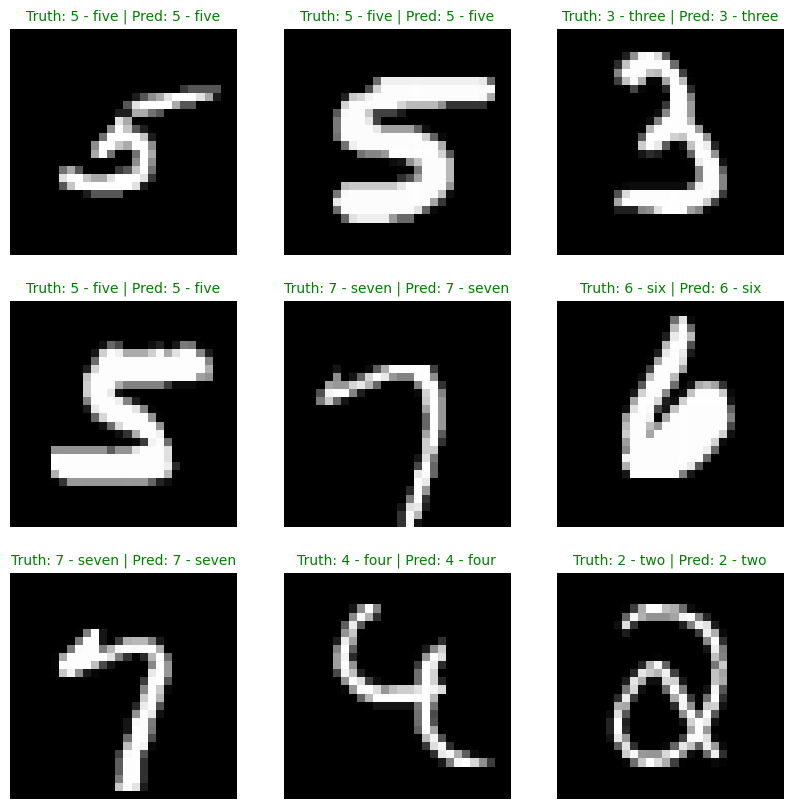

In [91]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    random_index = torch.randint(0, len(test_data), size=[1]).item()
    X, y = test_data[random_index]
    y_logit = model_on_cpu(X.unsqueeze(dim=0))
    y_pred = y_logit.argmax(dim=1)
    fig.add_subplot(3, 3, i)
    plt.imshow(X.squeeze(), cmap='gray')
    plt.axis(False)
    title = f'Truth: {classes_name[y]} | Pred: {classes_name[y_pred]}'
    if y == y_pred:
        plt.title(title,fontsize=10, c='g')
    else:
        plt.title(title, c='r')

Now plotting the confusion matrix

In [92]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [98]:
y_predictions = []
for X, y in test_dataloader:
    y_pred = model_on_cpu(X).argmax(dim=1)
    y_predictions.append(y_pred)
y_predictions = torch.cat(y_predictions)
y_predictions.shape

torch.Size([10000])

In [103]:
test_data.targets.shape

torch.Size([10000])

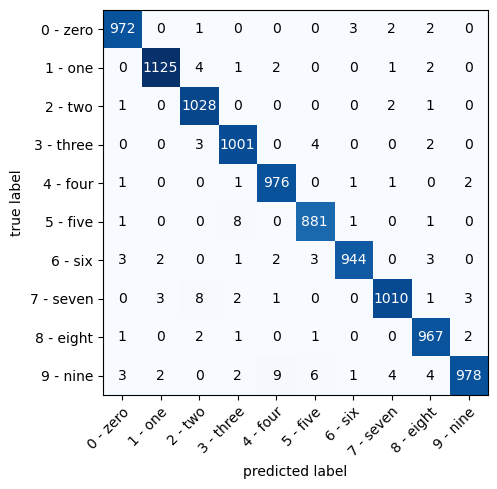

In [106]:
confmat = ConfusionMatrix(task='multiclass', num_classes=len(classes_name))
confmat_tensor = confmat(y_predictions, test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=classes_name, figsize=(5, 5))

Saving the model

In [112]:
from pathlib import Path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = 'MNIST_model.pth'
SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model_on_gpu.state_dict(),f=SAVE_PATH)